# Evaluate classification models & dump images for diagnosis/labelling

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib notebook
# %matplotlib inline

In [2]:
import sys

from catboost import CatBoostClassifier, Pool
from scipy.ndimage import binary_dilation
from sklearn import clone
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, BaggingClassifier
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split, StratifiedKFold, RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score, cross_val_predict, cross_validate
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier
from pathlib import Path
import numpy as np
import pandas as pd
from definitions import ROOT_DIR
import matplotlib.pyplot as plt
import seaborn as sns
from metaspace.sm_annotation_utils import SMInstance
from metaspace.image_processing import clip_hotspots

In [3]:
# Suppress warnings, because many models spam them during feature selection
# as some subsets of features just don't have enough information to make
# a good model.
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)

## Utility functions

In [4]:
def colorize_image_with_mask(image, mask):
    """Plotting function for combining a colorized ion image with a spot mask"""
    image = clip_hotspots(image)
    on_spot_colorized = plt.cm.cividis(image)
    off_spot_colorized = plt.cm.magma(image)
    return np.where(mask[:,:,np.newaxis], on_spot_colorized, off_spot_colorized)
    
def save_image_with_mask(image, mask, fname):
    plt.imsave(fname, colorize_image_with_mask(image, mask))

In [5]:
def crop_zeros(img):
    """Crop an image, removing all empty outer rows/columns"""
    cols = np.flatnonzero(np.count_nonzero(img, axis=0) != 0)
    rows = np.flatnonzero(np.count_nonzero(img, axis=1) != 0)
    top = rows[0]
    bottom = rows[-1] + 1
    left = cols[0]
    right = cols[-1] + 1

    return img[top:bottom, left:right]

In [6]:
def get_mispredictions(model, X, y):
    """
    Find which values would be mispredicted, returning two lists:
        * indexes of items that would be falsely predicted as positives
        * indexes of items that would be falsely predicted as negatives
        
    cross_val_predict uses a shuffled 5-fold test-train split so that each chunk of 
    20% of the input data gets its own model that was trained on the other 80%, 
    ensuring that the items being predicted aren't included in the training data.
    """
    preds = cross_val_predict(model, X, y)
    mispreds = preds != y
    fpos_idxs = np.flatnonzero(mispreds & ~y)
    fneg_idxs = np.flatnonzero(mispreds & y)
        
    return fpos_idxs, fneg_idxs

## Paths

In [7]:
p_root_dir = Path(ROOT_DIR)
p_grids = p_root_dir / "2_grid_calibration/grid_masks"
p_wellmap = p_root_dir / "3_metric_extraction/Well_2_compound.csv"
p_stats = p_root_dir / "4_metric_extension"
p_analysis = p_root_dir  / "5_well_classification"
p_labelled_set = p_analysis / "labelled_set"
p_datasets = p_labelled_set / "Datasets.csv"

# Paths for evaluation
p_eval = p_root_dir / "4_model_evaluation"
p_eval_preds = p_eval / 'predictions.csv'
# False positives/negatives - preview output from model prediction for molecules with known labels
# Note that all files in these directories are cleared before a prediction run
p_eval_fpos = p_eval / 'false_positives'
p_eval_fneg = p_eval / 'false_negatives'
p_eval_tpos = p_eval / 'true_positives'
p_eval_tneg = p_eval / 'true_negatives'
# Unknown positives/negatives - preview output from model prediction for molecules with no label
# Note that all files in these directories are cleared before a prediction run
p_eval_upos = p_eval / 'unknown_positives'
p_eval_uneg = p_eval / 'unknown_negatives'
# Manually labeled positives/negatives - Move preview files from any of the above directories into 
# these directories to add to the labelled data. Make sure to re-run the appropriate steps 
# in "Input data" to detect the changes
p_eval_lpos = p_eval / 'manual_label_positives'
p_eval_lneg = p_eval / 'manual_label_negatives'

# Directories for three-state positive/unsure/negative classification
p_tri_pos = p_eval / 'three-state' / 'positive'
p_tri_unk = p_eval / 'three-state' / 'unsure'
p_tri_neg = p_eval / 'three-state' / 'negative'


# METASPACE
database = ('Spotting_project_compounds-v9', 'feb2021')
fdr = 0.5

## Input data

In [8]:
# Get dataset IDs based on Quality_Labels.csv files 
dataset_ids = pd.concat([
    pd.read_csv(f)
    for f in p_labelled_set.rglob("*Quality_Labels.csv")
]).dataset_id.unique().tolist()


In [9]:
# Images from METASPACE
# NOTE: Hotspot clipping is applied at this step, so `np.max(image)` 
# represents the 99th percentile intensity for the rest of the script.
#
# Ignore any warnings about connection pools in this step

images = []
for i, ds_id in enumerate(dataset_ids):
    print(f'Downloading images for {ds_id} ({i}/{len(dataset_ids)})')
    for img in SMInstance().dataset(id=ds_id).all_annotation_images(
        fdr=fdr, 
        database=database, 
        only_first_isotope=True, 
        scale_intensity=False, 
        hotspot_clipping=True
    ):
        # Exclude annotations with no first-isotopic-image
        if img[0] is not None:
            images.append({
                'dataset_id': ds_id,
                'formula': img.formula,
                'adduct': img.adduct,
                'neutral_loss': img.neutral_loss or '',
                'image': img[0],
                'filename': f'{ds_id}_{img.formula}_{img.adduct}_{img.neutral_loss}.png'.replace('+', ''),
            })

images_df = pd.DataFrame(images)

2021-06-02 18:06:40,248 - WARNING - urllib3.connectionpool - connectionpool.py:304 - Connection pool is full, discarding connection: metaspace2020.eu
2021-06-02 18:06:40,274 - WARNING - urllib3.connectionpool - connectionpool.py:304 - Connection pool is full, discarding connection: metaspace2020.eu
2021-06-02 18:06:40,275 - WARNING - urllib3.connectionpool - connectionpool.py:304 - Connection pool is full, discarding connection: metaspace2020.eu
2021-06-02 18:06:40,314 - WARNING - urllib3.connectionpool - connectionpool.py:304 - Connection pool is full, discarding connection: metaspace2020.eu
2021-06-02 18:06:40,318 - WARNING - urllib3.connectionpool - connectionpool.py:304 - Connection pool is full, discarding connection: metaspace2020.eu
2021-06-02 18:06:40,318 - WARNING - urllib3.connectionpool - connectionpool.py:304 - Connection pool is full, discarding connection: metaspace2020.eu
2021-06-02 18:06:40,324 - WARNING - urllib3.connectionpool - connectionpool.py:304 - Connection pool

2021-06-02 18:06:47,068 - WARNING - urllib3.connectionpool - connectionpool.py:304 - Connection pool is full, discarding connection: metaspace2020.eu
2021-06-02 18:06:47,069 - WARNING - urllib3.connectionpool - connectionpool.py:304 - Connection pool is full, discarding connection: metaspace2020.eu
2021-06-02 18:06:47,091 - WARNING - urllib3.connectionpool - connectionpool.py:304 - Connection pool is full, discarding connection: metaspace2020.eu
2021-06-02 18:06:47,097 - WARNING - urllib3.connectionpool - connectionpool.py:304 - Connection pool is full, discarding connection: metaspace2020.eu
2021-06-02 18:06:47,137 - WARNING - urllib3.connectionpool - connectionpool.py:304 - Connection pool is full, discarding connection: metaspace2020.eu
2021-06-02 18:06:47,314 - WARNING - urllib3.connectionpool - connectionpool.py:304 - Connection pool is full, discarding connection: s3.eu-west-1.amazonaws.com
2021-06-02 18:06:47,315 - WARNING - urllib3.connectionpool - connectionpool.py:304 - Conne

2021-06-02 18:06:57,675 - WARNING - urllib3.connectionpool - connectionpool.py:304 - Connection pool is full, discarding connection: metaspace2020.eu
2021-06-02 18:06:57,677 - WARNING - urllib3.connectionpool - connectionpool.py:304 - Connection pool is full, discarding connection: metaspace2020.eu
2021-06-02 18:06:57,680 - WARNING - urllib3.connectionpool - connectionpool.py:304 - Connection pool is full, discarding connection: metaspace2020.eu
2021-06-02 18:06:57,682 - WARNING - urllib3.connectionpool - connectionpool.py:304 - Connection pool is full, discarding connection: metaspace2020.eu
2021-06-02 18:06:57,687 - WARNING - urllib3.connectionpool - connectionpool.py:304 - Connection pool is full, discarding connection: metaspace2020.eu
2021-06-02 18:06:57,693 - WARNING - urllib3.connectionpool - connectionpool.py:304 - Connection pool is full, discarding connection: metaspace2020.eu
2021-06-02 18:06:57,713 - WARNING - urllib3.connectionpool - connectionpool.py:304 - Connection pool

2021-06-02 18:07:04,228 - WARNING - urllib3.connectionpool - connectionpool.py:304 - Connection pool is full, discarding connection: metaspace2020.eu
2021-06-02 18:07:04,232 - WARNING - urllib3.connectionpool - connectionpool.py:304 - Connection pool is full, discarding connection: metaspace2020.eu
2021-06-02 18:07:04,234 - WARNING - urllib3.connectionpool - connectionpool.py:304 - Connection pool is full, discarding connection: metaspace2020.eu
2021-06-02 18:07:04,274 - WARNING - urllib3.connectionpool - connectionpool.py:304 - Connection pool is full, discarding connection: metaspace2020.eu
2021-06-02 18:07:04,292 - WARNING - urllib3.connectionpool - connectionpool.py:304 - Connection pool is full, discarding connection: metaspace2020.eu
2021-06-02 18:07:04,469 - WARNING - urllib3.connectionpool - connectionpool.py:304 - Connection pool is full, discarding connection: s3.eu-west-1.amazonaws.com
2021-06-02 18:07:04,478 - WARNING - urllib3.connectionpool - connectionpool.py:304 - Conne

2021-06-02 18:07:17,133 - WARNING - urllib3.connectionpool - connectionpool.py:304 - Connection pool is full, discarding connection: metaspace2020.eu
2021-06-02 18:07:17,138 - WARNING - urllib3.connectionpool - connectionpool.py:304 - Connection pool is full, discarding connection: metaspace2020.eu
2021-06-02 18:07:17,155 - WARNING - urllib3.connectionpool - connectionpool.py:304 - Connection pool is full, discarding connection: metaspace2020.eu
2021-06-02 18:07:17,379 - WARNING - urllib3.connectionpool - connectionpool.py:304 - Connection pool is full, discarding connection: s3.eu-west-1.amazonaws.com
2021-06-02 18:07:17,401 - WARNING - urllib3.connectionpool - connectionpool.py:304 - Connection pool is full, discarding connection: s3.eu-west-1.amazonaws.com
2021-06-02 18:07:17,434 - WARNING - urllib3.connectionpool - connectionpool.py:304 - Connection pool is full, discarding connection: s3.eu-west-1.amazonaws.com
2021-06-02 18:07:25,624 - WARNING - urllib3.connectionpool - connectio

2021-06-02 18:07:27,238 - WARNING - urllib3.connectionpool - connectionpool.py:304 - Connection pool is full, discarding connection: metaspace2020.eu
2021-06-02 18:07:27,240 - WARNING - urllib3.connectionpool - connectionpool.py:304 - Connection pool is full, discarding connection: metaspace2020.eu
2021-06-02 18:07:27,243 - WARNING - urllib3.connectionpool - connectionpool.py:304 - Connection pool is full, discarding connection: metaspace2020.eu
2021-06-02 18:07:27,243 - WARNING - urllib3.connectionpool - connectionpool.py:304 - Connection pool is full, discarding connection: metaspace2020.eu
2021-06-02 18:07:27,272 - WARNING - urllib3.connectionpool - connectionpool.py:304 - Connection pool is full, discarding connection: metaspace2020.eu
2021-06-02 18:07:27,274 - WARNING - urllib3.connectionpool - connectionpool.py:304 - Connection pool is full, discarding connection: metaspace2020.eu
2021-06-02 18:07:27,282 - WARNING - urllib3.connectionpool - connectionpool.py:304 - Connection pool

2021-06-02 18:07:35,288 - WARNING - urllib3.connectionpool - connectionpool.py:304 - Connection pool is full, discarding connection: metaspace2020.eu
2021-06-02 18:07:35,314 - WARNING - urllib3.connectionpool - connectionpool.py:304 - Connection pool is full, discarding connection: metaspace2020.eu
2021-06-02 18:07:35,315 - WARNING - urllib3.connectionpool - connectionpool.py:304 - Connection pool is full, discarding connection: metaspace2020.eu
2021-06-02 18:07:35,316 - WARNING - urllib3.connectionpool - connectionpool.py:304 - Connection pool is full, discarding connection: metaspace2020.eu
2021-06-02 18:07:35,319 - WARNING - urllib3.connectionpool - connectionpool.py:304 - Connection pool is full, discarding connection: metaspace2020.eu
2021-06-02 18:07:35,323 - WARNING - urllib3.connectionpool - connectionpool.py:304 - Connection pool is full, discarding connection: metaspace2020.eu
2021-06-02 18:07:35,323 - WARNING - urllib3.connectionpool - connectionpool.py:304 - Connection pool

2021-06-02 18:07:52,562 - WARNING - urllib3.connectionpool - connectionpool.py:304 - Connection pool is full, discarding connection: metaspace2020.eu
2021-06-02 18:07:52,574 - WARNING - urllib3.connectionpool - connectionpool.py:304 - Connection pool is full, discarding connection: metaspace2020.eu
2021-06-02 18:07:52,576 - WARNING - urllib3.connectionpool - connectionpool.py:304 - Connection pool is full, discarding connection: metaspace2020.eu
2021-06-02 18:07:52,578 - WARNING - urllib3.connectionpool - connectionpool.py:304 - Connection pool is full, discarding connection: metaspace2020.eu
2021-06-02 18:07:52,605 - WARNING - urllib3.connectionpool - connectionpool.py:304 - Connection pool is full, discarding connection: metaspace2020.eu
2021-06-02 18:07:52,612 - WARNING - urllib3.connectionpool - connectionpool.py:304 - Connection pool is full, discarding connection: metaspace2020.eu
2021-06-02 18:07:52,663 - WARNING - urllib3.connectionpool - connectionpool.py:304 - Connection pool

2021-06-02 18:07:54,420 - WARNING - urllib3.connectionpool - connectionpool.py:304 - Connection pool is full, discarding connection: metaspace2020.eu
2021-06-02 18:07:54,433 - WARNING - urllib3.connectionpool - connectionpool.py:304 - Connection pool is full, discarding connection: metaspace2020.eu
2021-06-02 18:07:54,439 - WARNING - urllib3.connectionpool - connectionpool.py:304 - Connection pool is full, discarding connection: metaspace2020.eu
2021-06-02 18:07:54,443 - WARNING - urllib3.connectionpool - connectionpool.py:304 - Connection pool is full, discarding connection: metaspace2020.eu
2021-06-02 18:07:54,447 - WARNING - urllib3.connectionpool - connectionpool.py:304 - Connection pool is full, discarding connection: metaspace2020.eu
2021-06-02 18:07:54,447 - WARNING - urllib3.connectionpool - connectionpool.py:304 - Connection pool is full, discarding connection: metaspace2020.eu
2021-06-02 18:07:54,450 - WARNING - urllib3.connectionpool - connectionpool.py:304 - Connection pool

2021-06-02 18:08:06,044 - WARNING - urllib3.connectionpool - connectionpool.py:304 - Connection pool is full, discarding connection: metaspace2020.eu
2021-06-02 18:08:06,047 - WARNING - urllib3.connectionpool - connectionpool.py:304 - Connection pool is full, discarding connection: metaspace2020.eu
2021-06-02 18:08:06,052 - WARNING - urllib3.connectionpool - connectionpool.py:304 - Connection pool is full, discarding connection: metaspace2020.eu
2021-06-02 18:08:06,366 - WARNING - urllib3.connectionpool - connectionpool.py:304 - Connection pool is full, discarding connection: s3.eu-west-1.amazonaws.com
2021-06-02 18:08:06,371 - WARNING - urllib3.connectionpool - connectionpool.py:304 - Connection pool is full, discarding connection: s3.eu-west-1.amazonaws.com
2021-06-02 18:08:06,382 - WARNING - urllib3.connectionpool - connectionpool.py:304 - Connection pool is full, discarding connection: s3.eu-west-1.amazonaws.com
2021-06-02 18:08:11,279 - WARNING - urllib3.connectionpool - connectio

2021-06-02 18:08:13,329 - WARNING - urllib3.connectionpool - connectionpool.py:304 - Connection pool is full, discarding connection: metaspace2020.eu
2021-06-02 18:08:13,366 - WARNING - urllib3.connectionpool - connectionpool.py:304 - Connection pool is full, discarding connection: metaspace2020.eu
2021-06-02 18:08:13,370 - WARNING - urllib3.connectionpool - connectionpool.py:304 - Connection pool is full, discarding connection: metaspace2020.eu
2021-06-02 18:08:13,388 - WARNING - urllib3.connectionpool - connectionpool.py:304 - Connection pool is full, discarding connection: metaspace2020.eu
2021-06-02 18:08:13,388 - WARNING - urllib3.connectionpool - connectionpool.py:304 - Connection pool is full, discarding connection: metaspace2020.eu
2021-06-02 18:08:13,423 - WARNING - urllib3.connectionpool - connectionpool.py:304 - Connection pool is full, discarding connection: metaspace2020.eu
2021-06-02 18:08:13,429 - WARNING - urllib3.connectionpool - connectionpool.py:304 - Connection pool

2021-06-02 18:08:25,626 - WARNING - urllib3.connectionpool - connectionpool.py:304 - Connection pool is full, discarding connection: metaspace2020.eu
2021-06-02 18:08:25,632 - WARNING - urllib3.connectionpool - connectionpool.py:304 - Connection pool is full, discarding connection: metaspace2020.eu
2021-06-02 18:08:25,632 - WARNING - urllib3.connectionpool - connectionpool.py:304 - Connection pool is full, discarding connection: metaspace2020.eu
2021-06-02 18:08:25,638 - WARNING - urllib3.connectionpool - connectionpool.py:304 - Connection pool is full, discarding connection: metaspace2020.eu
2021-06-02 18:08:25,651 - WARNING - urllib3.connectionpool - connectionpool.py:304 - Connection pool is full, discarding connection: metaspace2020.eu
2021-06-02 18:08:25,667 - WARNING - urllib3.connectionpool - connectionpool.py:304 - Connection pool is full, discarding connection: metaspace2020.eu
2021-06-02 18:08:25,673 - WARNING - urllib3.connectionpool - connectionpool.py:304 - Connection pool

2021-06-02 18:08:37,406 - WARNING - urllib3.connectionpool - connectionpool.py:304 - Connection pool is full, discarding connection: metaspace2020.eu
2021-06-02 18:08:37,408 - WARNING - urllib3.connectionpool - connectionpool.py:304 - Connection pool is full, discarding connection: metaspace2020.eu
2021-06-02 18:08:37,412 - WARNING - urllib3.connectionpool - connectionpool.py:304 - Connection pool is full, discarding connection: metaspace2020.eu
2021-06-02 18:08:37,420 - WARNING - urllib3.connectionpool - connectionpool.py:304 - Connection pool is full, discarding connection: metaspace2020.eu
2021-06-02 18:08:37,448 - WARNING - urllib3.connectionpool - connectionpool.py:304 - Connection pool is full, discarding connection: metaspace2020.eu
2021-06-02 18:08:37,464 - WARNING - urllib3.connectionpool - connectionpool.py:304 - Connection pool is full, discarding connection: metaspace2020.eu
2021-06-02 18:08:37,471 - WARNING - urllib3.connectionpool - connectionpool.py:304 - Connection pool

2021-06-02 18:08:44,616 - WARNING - urllib3.connectionpool - connectionpool.py:304 - Connection pool is full, discarding connection: metaspace2020.eu
2021-06-02 18:08:44,635 - WARNING - urllib3.connectionpool - connectionpool.py:304 - Connection pool is full, discarding connection: metaspace2020.eu
2021-06-02 18:08:44,871 - WARNING - urllib3.connectionpool - connectionpool.py:304 - Connection pool is full, discarding connection: s3.eu-west-1.amazonaws.com
2021-06-02 18:08:49,792 - WARNING - urllib3.connectionpool - connectionpool.py:304 - Connection pool is full, discarding connection: metaspace2020.eu
2021-06-02 18:08:49,795 - WARNING - urllib3.connectionpool - connectionpool.py:304 - Connection pool is full, discarding connection: metaspace2020.eu
2021-06-02 18:08:49,806 - WARNING - urllib3.connectionpool - connectionpool.py:304 - Connection pool is full, discarding connection: metaspace2020.eu
2021-06-02 18:08:49,826 - WARNING - urllib3.connectionpool - connectionpool.py:304 - Conne

In [10]:
# Wellmap and grids
wellmap = pd.read_csv(p_wellmap)
grids = {
    ds_id: np.load(p_grids / f'{ds_id}.npy') 
    for ds_id in dataset_ids
}

In [11]:
# Image labels from Quality_Labels.csv files
labeled_anns = []
for i in p_labelled_set.rglob("*Quality_Labels.csv"):
    data = pd.read_csv(i)
    data = data.loc[:, ['dataset_id', 'formula', 'adduct', 'neutral_loss', 'score']]
    data.neutral_loss.fillna('', inplace=True)
    labeled_anns.append(data)

labeled_anns_df = pd.concat(labeled_anns)

### Import image labels from the manual_label directories

If you these directories for labelling, re-run every cell from this point onwards

In [12]:
# Image labels from the "manual_label" directories
manual_labels = []
for score, labels_path in [(1, p_eval_lpos), (0, p_eval_lneg)]:
    labels_path.mkdir(parents=True, exist_ok=True)
    for f in labels_path.glob('*.png'):
        labeled_imgs.append({
            'filename': f.name,
            'manual_score': score,
        })
if manual_labels:
    manual_labels_df = pd.DataFrame(manual_labels)
else:
    manual_labels_df = pd.DataFrame({'filename': pd.Series(dtype=str), 'manual_score': pd.Series(dtype='i')})

In [13]:
# Combine them for easier access
merged_df = (
    images_df
    # Add `how=left` when merging with wellmap to include non-spotted formulas
    .merge(wellmap[['well', 'formula', 'name']], on=['formula'])
    .merge(labeled_anns_df, on=['dataset_id', 'formula', 'adduct', 'neutral_loss'], how='left')
    .merge(manual_labels_df, on='filename', how='left')
).reset_index()

# Merge the "manual_score" column into "score"
merged_df['score'] = np.where(merged_df.score.isna(), merged_df.manual_score, merged_df.score)
del merged_df['manual_score']

## Calculate metrics

In [14]:
def calc_far_bg(mask, bg):
    """Gets mask for background pixels that are at least 4 radii away from the spot"""
    # 3 iterations = (1+3=)4x the spot radius
    expanded_spot = binary_dilation(mask, crop_zeros(mask), iterations=3)
    return bg & ~expanded_spot

def occ(px):
    """Calculates non-zero % of the given array"""
    return np.count_nonzero(px) / px.size


metrics = []
for row in merged_df.itertuples():
    grid = grids[row.dataset_id]
    
    mask = grid == row.well
    bg = grid == 0
    far_bg = calc_far_bg(mask, bg)
        
    in_mask = row.image[mask]
    in_bg = row.image[bg]
    in_far_bg = row.image[far_bg]
    in_other_spots = row.image[~bg & ~mask]
    
    # Calculate threshold (0.01 * 99th percentile) 
    # (note the image is already hotspot-removed, so the max is the 99th percentile)
    threshold = np.max(row.image) * 0.01

    metrics.append({
        # Original metrics
        # NOTE: The constant in the denominator of `on_off_ratio` was changed to
        # 0.001 as it seemed to produce slightly better results
        'occupancy_ratio': (occ(in_mask) * 100) / (occ(in_bg) * 100 + 1),
        'on_off_ratio': (np.mean(in_mask)) / (np.mean(in_bg) + 0.001),
        
        # Single-spot occupancy %
        'spot_occupancy': occ(in_mask),
        'spot_occupancy_thresholded': occ(in_mask > threshold),
        # Other occupancy metrics
        'image_occupancy': occ(row.image),
        'other_spots_occupancy': occ(in_other_spots),
        'bg_occupancy': occ(in_bg),
        'far_bg_occupancy': occ(in_bg),
        
        # How many spots have a non-zero pixel
        'in_n_spots': len(np.unique(grid[(grid != 0) & (row.image > threshold)])),
        
        # Intensity ratios
        'intensity_vs_other_spots_ratio': np.mean(in_mask) / (np.mean(in_other_spots) + 0.001),
        'intensity_vs_far_bg_ratio': np.mean(in_mask) / (np.mean(in_far_bg) + 0.001),
        
        'score': row.score,
    })

metrics_df = pd.DataFrame(metrics, index=merged_df.index)
metrics_df.head()

,occupancy_ratio,on_off_ratio,spot_occupancy,spot_occupancy_thresholded,image_occupancy,other_spots_occupancy,bg_occupancy,far_bg_occupancy,in_n_spots,intensity_vs_other_spots_ratio,intensity_vs_far_bg_ratio,score
0,76.822382,186.974797,0.788462,0.730769,0.001346,0.000102,0.000263,0.000263,1,188.467737,188.632935,nan
1,76.263104,260.779729,0.788462,0.769231,0.001978,0.002250,0.000339,0.000339,4,218.980531,265.709822,nan
2,0.000000,0.000000,0.000000,0.000000,0.000330,0.000511,0.000263,0.000263,3,0.000000,0.000000,nan
3,55.769231,43.525465,0.557692,0.326923,0.000799,0.000000,0.000000,0.000000,1,43.525465,43.525465,nan
4,9.292805,15.742199,0.115385,0.115385,0.003278,0.005018,0.002417,0.002417,33,8.379454,15.726048,nan


## Evaluate models

This section uses the calculated metrics and labeled data to train a set of models 
and find which features are best for predicting the labels. 
It uses two strategies for evaluation:

* Hold-out validation - this splits the labeled data into 80% for training, 20% for testing
* Cross-Validation - this uses the full labeled data, but trains 5 different models, each
    with a different combinations of inputs in the 80% training set, so that each input 
    can be tested by a model that didn't use that input as part of the training.
    This approach reports a much more numerically stable accuracy value it can use 
    the full input set for evaluation.
    However, it shouldn't be used for fine-tuning the model hyperparameters 
    (the input variables when constructing the model), as this can lead to overfitting.
    
   
The output is a DataFrame `eval_results_df` that shows for each model/# of features:
* Which combination of features worked best
* The accuracy/F1 scores
* The # of false positives & false negatives

In [15]:
# Prepare input data
input_df = metrics_df[~metrics_df.score.isna()]  # Exclude unlabeled rows
input_df = input_df.sample(frac=1.0)  # Shuffle rows
X = input_df.drop(columns=['score'])
y = input_df.score.astype('i').values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

In [16]:
# Models to try
models_to_eval = [
    CatBoostClassifier(verbose=False),
    LinearSVC(class_weight='balanced'),
    DecisionTreeClassifier(max_depth=3),
    BaggingClassifier(LinearSVC(), n_estimators=3, bootstrap_features=True),
]
max_features_to_consider = 5

eval_results = []

for model in models_to_eval:
    model_name = str(model)
    for n_features in range(1, max_features_to_consider + 1):
        print(model_name, n_features)
        # SequentialFeatureSelector finds the set of N features that give the best scores
        sfs = SequentialFeatureSelector(model, n_features_to_select=n_features, n_jobs=-1)
        sfs.fit(X_train, y_train)
        best_features = X.columns[sfs.support_]
        
        # Evaluate using cross-validation
        X_subset = X[best_features].values
        fpos_idxs, fneg_idxs = get_mispredictions(model, X_subset, y)
        # Use a repeating cross-validator so that results are averaged over ~50 runs
        cv = RepeatedStratifiedKFold()
        cv_scores = cross_validate(model, X_subset, y, cv=cv, scoring=['accuracy','f1'])
        cv_accuracy = np.mean(cv_scores['test_accuracy'])
        cv_f1 = np.mean(cv_scores['test_f1'])
        
        # Evaluate using hold-out validation
        trained_subset_model = clone(model).fit(X_train[best_features].values, y_train)
        holdout_accuracy = trained_subset_model.score(X_test[best_features].values, y_test)
        holdout_f1 = f1_score(y_test, trained_subset_model.predict(X_test[best_features].values))
        
        eval_results.append({
            'model': model_name,
            'n_features': n_features,
            'features': ', '.join(best_features),
            'cv_accuracy': cv_accuracy,
            'cv_f1': cv_f1,
            'holdout_accuracy': holdout_accuracy,
            'holdout_f1': holdout_f1,
            'n_fpos': len(fpos_idxs),
            'n_fneg': len(fneg_idxs),
            # Uncomment to include the idxs of false positives/negatives to see which
            # inputs are repeatedly mispredicted regardless of the model
            # 'fpos_idxs': fpos_idxs,
            # 'fneg_idxs': fneg_idxs,
        })
        
eval_results_df = pd.DataFrame(eval_results)

eval_results_df

<catboost.core.CatBoostClassifier object at 0x7efdcb2a2a90> 1
<catboost.core.CatBoostClassifier object at 0x7efdcb2a2a90> 2
<catboost.core.CatBoostClassifier object at 0x7efdcb2a2a90> 3
<catboost.core.CatBoostClassifier object at 0x7efdcb2a2a90> 4
<catboost.core.CatBoostClassifier object at 0x7efdcb2a2a90> 5
LinearSVC(class_weight='balanced') 1
LinearSVC(class_weight='balanced') 2
LinearSVC(class_weight='balanced') 3
LinearSVC(class_weight='balanced') 4
LinearSVC(class_weight='balanced') 5
DecisionTreeClassifier(max_depth=3) 1
DecisionTreeClassifier(max_depth=3) 2
DecisionTreeClassifier(max_depth=3) 3
DecisionTreeClassifier(max_depth=3) 4
DecisionTreeClassifier(max_depth=3) 5
BaggingClassifier(base_estimator=LinearSVC(), bootstrap_features=True,
                  n_estimators=3) 1
BaggingClassifier(base_estimator=LinearSVC(), bootstrap_features=True,
                  n_estimators=3) 2
BaggingClassifier(base_estimator=LinearSVC(), bootstrap_features=True,
                  n_estimators

,model,n_features,features,cv_accuracy,cv_f1,holdout_accuracy,holdout_f1,n_fpos,n_fneg
0,<catboost.core.CatBoostClassifier object at 0x7efdcb2a2a90>,1,occupancy_ratio,0.889814,0.913643,0.890110,0.915254,17,37
1,<catboost.core.CatBoostClassifier object at 0x7efdcb2a2a90>,2,"occupancy_ratio, spot_occupancy_thresholded",0.906381,0.928040,0.901099,0.924370,16,28
2,<catboost.core.CatBoostClassifier object at 0x7efdcb2a2a90>,3,"occupancy_ratio, spot_occupancy_thresholded, intensity_vs_other_spots_ratio",0.937661,0.952641,0.923077,0.941176,11,20
3,<catboost.core.CatBoostClassifier object at 0x7efdcb2a2a90>,4,"occupancy_ratio, spot_occupancy, spot_occupancy_thresholded, intensity_vs_other_spots_ratio",0.937680,0.952571,0.923077,0.941176,11,17
4,<catboost.core.CatBoostClassifier object at 0x7efdcb2a2a90>,5,"occupancy_ratio, on_off_ratio, spot_occupancy, spot_occupancy_thresholded, intensity_vs_other_spots_ratio",0.934347,0.950214,0.901099,0.923077,9,20
5,LinearSVC(class_weight='balanced'),1,occupancy_ratio,0.879534,0.901141,0.901099,0.921739,1,52
6,LinearSVC(class_weight='balanced'),2,"occupancy_ratio, spot_occupancy",0.885490,0.906334,0.901099,0.921739,1,51
7,LinearSVC(class_weight='balanced'),3,"occupancy_ratio, on_off_ratio, spot_occupancy",0.884581,0.906138,0.901099,0.923077,3,49
8,LinearSVC(class_weight='balanced'),4,"occupancy_ratio, on_off_ratio, spot_occupancy, other_spots_occupancy",0.894498,0.914979,0.901099,0.923077,3,44
9,LinearSVC(class_weight='balanced'),5,"occupancy_ratio, spot_occupancy, image_occupancy, intensity_vs_other_spots_ratio, intensity_vs_far_bg_ratio",0.892525,0.913328,0.901099,0.923077,2,48


<IPython.core.display.Javascript object>


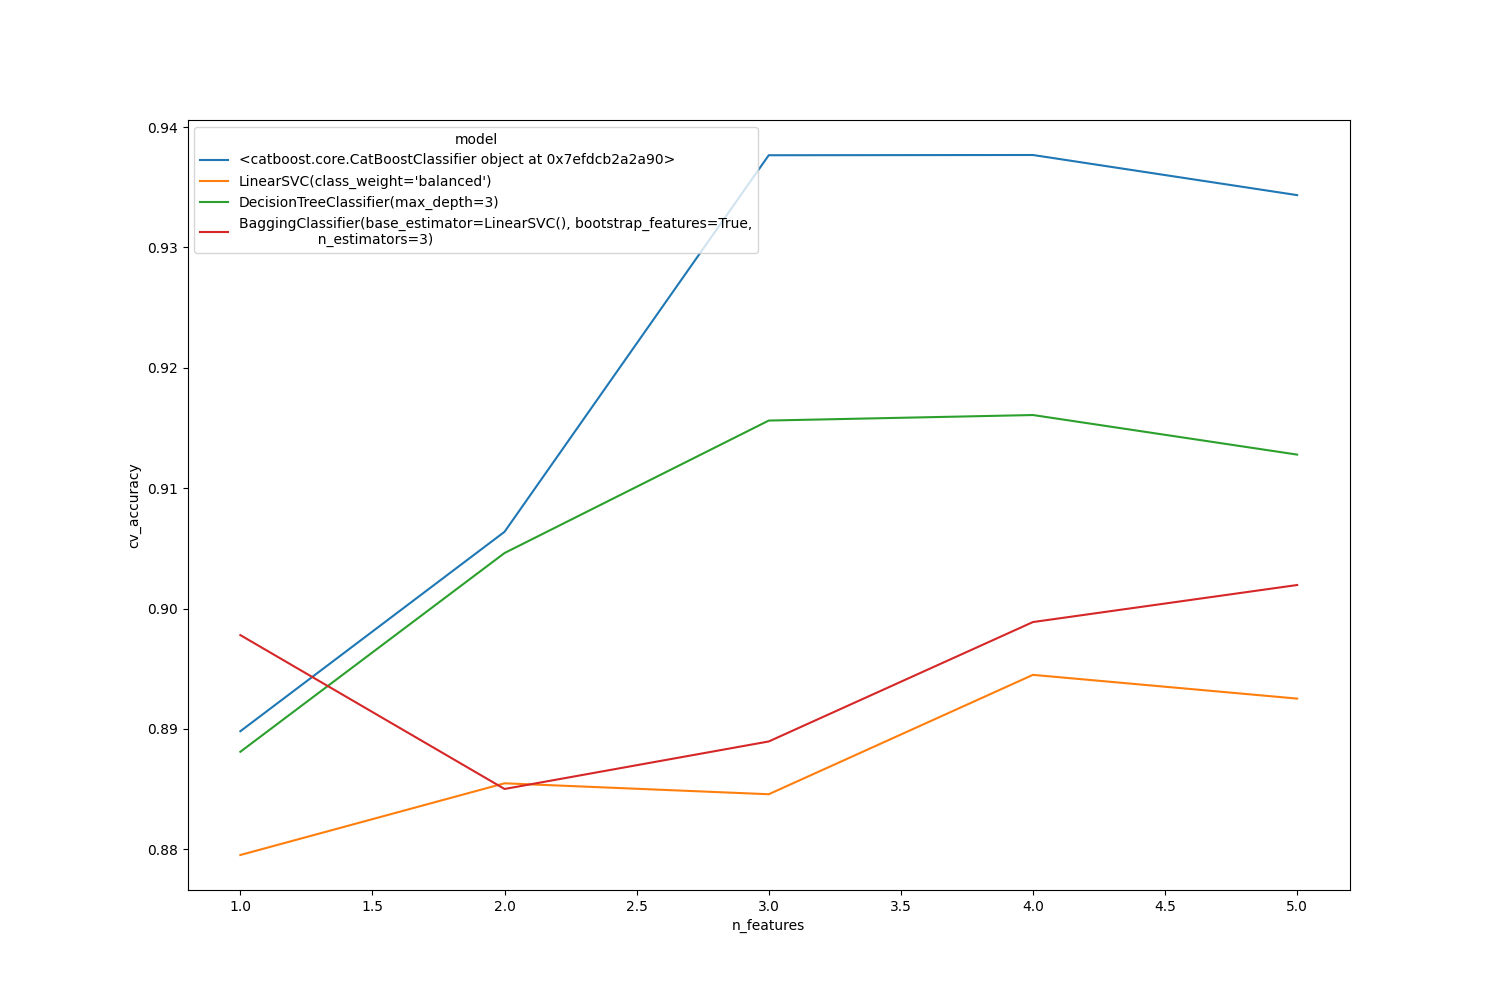

2021-06-02 18:22:29,879 - INFO - numexpr.utils - utils.py:157 - NumExpr defaulting to 4 threads.


<AxesSubplot:xlabel='n_features', ylabel='cv_accuracy'>

In [17]:
# Show behavior of accuracy as number of features increases
sns.lineplot(data=eval_results_df, x='n_features', y='cv_accuracy', hue='model')

## Examine results for a specific model

In [18]:
model = CatBoostClassifier(verbose=False)
features = ['occupancy_ratio', 'on_off_ratio', 'intensity_vs_other_spots_ratio', 'spot_occupancy_thresholded']

### Option A: Train a new model

In [21]:
# Train the model on labeled data
train_df = metrics_df[~metrics_df.score.isna()]  # Exclude unlabeled rows
train_df = input_df.sample(frac=1.0)  # Shuffle rows
X_df = train_df.drop(columns=['score'])[features]
y = train_df.score.astype('i').values
trained_model = clone(model).fit(X_df.values, y)

# Make predictions for unlabeled data
unlabeled_df = metrics_df[metrics_df.score.isna()][features]
unlabeled_predictions_df = pd.DataFrame({
    'pred_val': trained_model.predict_proba(unlabeled_df.values)[:, 1]
}, index=unlabeled_df.index)

# Make cross-validated predictions for labeled data
labeled_predictions_df = pd.DataFrame({
    'pred_val': cross_val_predict(model, X_df.values, y, method='predict_proba')[:, 1]
}, index=X.index)

# Combine predictions
predictions_df = pd.concat([unlabeled_predictions_df, labeled_predictions_df])

### Option B: Load an existing model
Uses a saved model from the last step of this file

NOTE: This approach doesn't use cross-validated predictions for the labelled training data,
so it shouldn't be used for analyzing the model or refining the training set.

In [ ]:
model.load_model(p_eval / 'model.json', format='json')

# Make predictions for all data
predictions_df = pd.DataFrame({
    'pred_val': model.predict_proba(metrics_df[features].values)[:, 1]
}, index=metrics_df.index)

### Both options: Assign labels to predictions

In [26]:
# Make combined DF
output_df = merged_df.drop(columns='score').join(metrics_df).join(predictions_df)

# Add two-state and three-state classes
output_df['pred_twostate'] = np.where(output_df.pred_val < 0.5, 0, 1)
unsure_range = [0.2, 0.8] # Lowest & highest values to include in the "unsure" class
# This assigns 0 = negative, 1 = unsure, 2 = positive
output_df['pred_threestate'] = np.digitize(output_df.pred_val, unsure_range)

### Write predictions CSV files

In [27]:
csv_df = output_df.drop(columns=['image', 'filename']) # Skip unwanted columns

for dataset_id, results_df in csv_df.groupby('dataset_id'):
    output_path = p_eval / f'{dataset_id}_predictions.csv'
    results_df.to_csv(output_path)

### Write image files into false positives, false negatives, etc.

In [28]:
# Clean output directories
for output_path in [
    p_eval_fpos, p_eval_fneg, p_eval_tpos, p_eval_tneg, p_eval_upos, p_eval_uneg, 
    p_tri_pos, p_tri_unk, p_tri_neg
]:
    output_path.mkdir(parents=True, exist_ok=True)
    for f in output_path.glob('*.png'):
        f.unlink()  # Delete existing files

# Write images with two-state classification
for row in output_df.itertuples():
    mask = grids[row.dataset_id] == row.well
    
    # Figure out which directory to use
    if row.score == 0:
        twostate_path = [p_eval_tneg, p_eval_fpos][row.pred_twostate]
    elif row.score == 1:
        twostate_path = [p_eval_fneg, p_eval_tpos][row.pred_twostate]
    else:
        twostate_path = [p_eval_uneg, p_eval_upos][row.pred_twostate]
    
    save_image_with_mask(row.image, mask, twostate_path / row.filename)
    
# Write images with three-state classification
for row in output_df.itertuples():
    mask = grids[row.dataset_id] == row.well
    
    threestate_path = [p_tri_pos, p_tri_unk, p_tri_neg][row.pred_threestate]
    
    save_image_with_mask(row.image, mask, threestate_path / row.filename)

# Save trained model

Note: This JSON export only works for CatBoost. 
scikit-learn models don't have a standardized export format.

In [25]:
trained_model.save_model(p_eval / 'model.json', format='json', pool=Pool(X_df.values, y))